<h1> Lab 3

In [3]:
#Basic packages
import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
import warnings     #Supress warnings
warnings.filterwarnings("ignore")
#sklearn basics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.inspection import permutation_importance
#GP imports
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
#other clasical regressors
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
#for Bayesian plotting
from scipy.stats import norm
#handy function to return RMSE
def root_mean_squared_error(y, yhat):
    return np.sqrt(mean_squared_error(y, yhat))

<h3> Exercise Set 1: Bayesian Updating

Our prior is:
$$
    p(\theta) = \frac 1 {\tau_0\sqrt{2\pi}}e^{-\frac {(\theta-\theta_0)^2} {2\tau_0^2}}
$$

Our single-draw likelihood is:
$$
    p(x_i|\theta) = \frac 1 {\sigma\sqrt{2\pi}}e^{-\frac {(x_i-\theta)^2} {2\sigma^2}}
$$

So our likelihood function is:
$$
    p(x|\theta) = \prod_{i}p(x_i|\theta) = \frac 1 {\sigma\sqrt{2\pi}}e^{-\frac 1 {2\sigma^2}\sum_{i}(x_i-\theta)^2}
$$

By Bayes' Theorem this implies our posterior is:
$$
    p(\theta|x) = \frac 1 {\tau_0\sqrt{2\pi}}e^{-\frac {(\theta-\theta_0)^2} {2\tau_0^2}}\frac 1 {\sigma\sqrt{2\pi}}e^{-\frac 1 {2\sigma^2}\sum_{i}(x_i-\theta)^2}
$$

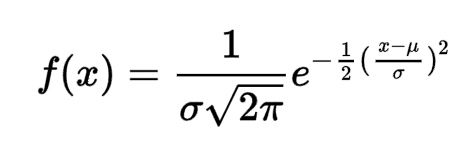
